In [1]:
# Install required packages (run once)
!pip install tensorflow streamlit pillow matplotlib pandas scikit-learn seaborn

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
import random

print("All imports successful!")
print("TensorFlow version:", tf.__version__)

All imports successful!
TensorFlow version: 2.20.0


In [ ]:
import zipfile
import os

# Extract the dataset
zip_path = r'C:\project_5\Dataset.zip'
extract_to = 'data'

print("📦 Extracting dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
print("✅ Extraction completed!")

# See what's inside
print("\n📁 Contents of data folder:")
print(os.listdir('data'))

📦 Extracting dataset...
✅ Extraction completed!

📁 Contents of data folder:
['images.cv_jzk6llhf18tm3k0kyttxz']


In [5]:
# Let's explore what we have
print("🔍 Exploring dataset structure...")

def explore_folder(path, level=0):
    """Recursively explore folder structure"""
    indent = "  " * level
    items = os.listdir(path)
    
    for item in items:
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            print(f"{indent}📁 {item}/")
            # Count images in this folder
            image_files = [f for f in os.listdir(item_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                print(f"{indent}   🖼️  {len(image_files)} images")
            explore_folder(item_path, level + 1)
        else:
            if item.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"{indent}🖼️  {item}")
            else:
                print(f"{indent}📄 {item}")

# Start exploring from the data folder
explore_folder('data')

🔍 Exploring dataset structure...
📁 images.cv_jzk6llhf18tm3k0kyttxz/
  📁 data/
    📁 test/
      📁 animal fish/
         🖼️  520 images
        🖼️  00ZR1T3Q2G5Z.jpg
        🖼️  0982EFXJOXH9.jpg
        🖼️  0AKFISD3OVLE.jpg
        🖼️  0AUE3U3PPXVL.jpg
        🖼️  0BJD9F3STSQ7.jpg
        🖼️  0JESIL2U7PFG.jpg
        🖼️  0JIAU5EUSBUU.jpg
        🖼️  0JW3T28ZMSLG.jpg
        🖼️  0KEIWNOMCIQU.jpg
        🖼️  0NBI29HSVDH5.jpg
        🖼️  0R3XC3NOXBG8.jpg
        🖼️  0RM3T5TX3M8F.jpg
        🖼️  0TJ97EPSV0F8.jpg
        🖼️  0YZ2CDNLQR51.jpg
        🖼️  0ZMAZ3IHFRJ9.jpg
        🖼️  10AHPT8T9F9O.jpg
        🖼️  10VDBW2QE3EF.jpg
        🖼️  11CCTP2PJ8L6.jpg
        🖼️  11HM809IQ82A.jpg
        🖼️  12KH710RRVXW.jpg
        🖼️  146YFQBQF6NK.jpg
        🖼️  14EEPCPKFGH3.jpg
        🖼️  15ZOR0SIDPD6.jpg
        🖼️  19E8NK0SOYRA.jpg
        🖼️  1CRFP2VE8TDL.jpg
        🖼️  1D6UG4LKM3EF.jpg
        🖼️  1ECI5A2Y05SA.jpg
        🖼️  1HUPOHC34OS3.jpg
        🖼️  1NB58KBMMAHF.jpg
        🖼️  1NJNC6ODP5R6

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print("🔄 Setting up data generators with exact paths...")

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    validation_split=0.2      # Use 20% of training data for validation
)

# For testing - no augmentation, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

print("📂 Creating training generator...")
train_generator = train_datagen.flow_from_directory(
    'data/images.cv_jzk6llhf18tm3k0kyttxz/data/Train',  # ✅ EXACT PATH
    target_size=IMG_SIZE,     # Resize all images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    subset='training'         # Use this subset for training
)

print("📂 Creating validation generator...")
val_generator = train_datagen.flow_from_directory(
    'data/images.cv_jzk6llhf18tm3k0kyttxz/data/Train',  # ✅ EXACT PATH
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'       # Use this subset for validation
)

print("📂 Creating test generator...")
test_generator = test_datagen.flow_from_directory(
    'data/images.cv_jzk6llhf18tm3k0kyttxz/data/Test',   # ✅ EXACT PATH
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False            # Don't shuffle test data
)

# Get class information
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print(f"\n✅ SUCCESS! Dataset loaded:")
print(f"🎯 Number of classes: {num_classes}")
print(f"🐟 Class names: {class_names}")
print(f"📚 Training samples: {train_generator.samples}")
print(f"📊 Validation samples: {val_generator.samples}")
print(f"🧪 Test samples: {test_generator.samples}")

# Let's see a sample batch
print(f"\n🔍 Sample batch shape: {next(train_generator)[0].shape}")

🔄 Setting up data generators with exact paths...
📂 Creating training generator...
Found 4984 images belonging to 11 classes.
📂 Creating validation generator...
Found 1241 images belonging to 11 classes.
📂 Creating test generator...
Found 3187 images belonging to 11 classes.

✅ SUCCESS! Dataset loaded:
🎯 Number of classes: 11
🐟 Class names: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']
📚 Training samples: 4984
📊 Validation samples: 1241
🧪 Test samples: 3187

🔍 Sample batch shape: (32, 224, 224, 3)


🖼️ Visualizing sample images from each class...


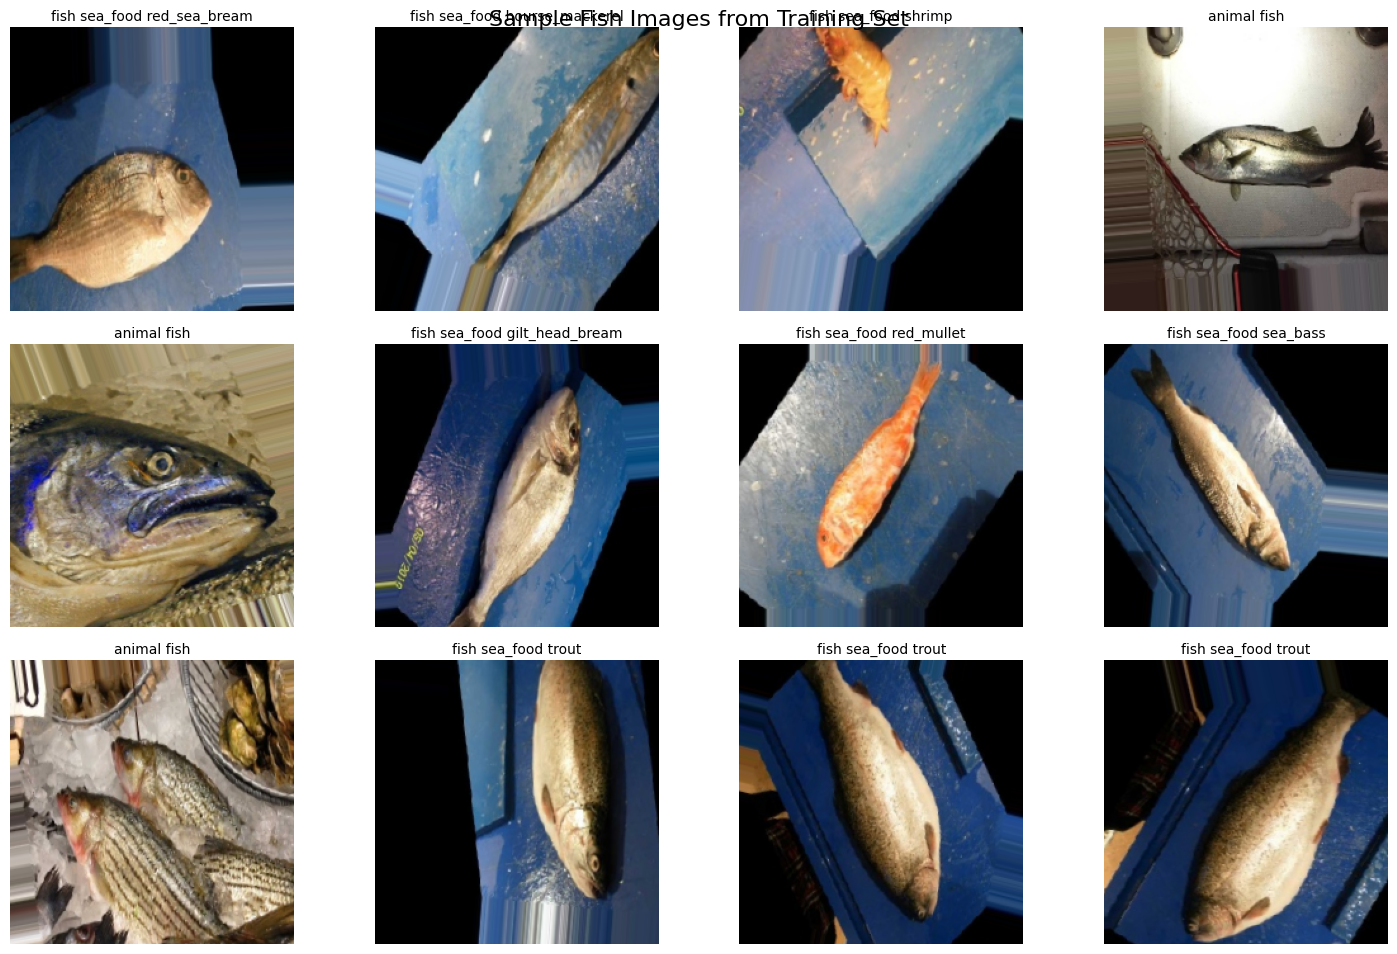


📊 DATASET SUMMARY:
Total classes: 11
Training images: 4984
Validation images: 1241
Test images: 3187
Batch size: 32
Image size: (224, 224)

🐟 FISH CLASSES:
  1. animal fish
  2. animal fish bass
  3. fish sea_food black_sea_sprat
  4. fish sea_food gilt_head_bream
  5. fish sea_food hourse_mackerel
  6. fish sea_food red_mullet
  7. fish sea_food red_sea_bream
  8. fish sea_food sea_bass
  9. fish sea_food shrimp
  10. fish sea_food striped_red_mullet
  11. fish sea_food trout


In [10]:
import matplotlib.pyplot as plt

print("🖼️ Visualizing sample images from each class...")

# Get one batch of images
images, labels = next(train_generator)

# Create a nice visualization
plt.figure(figsize=(15, 10))

# Display 12 random images from the batch
for i in range(12):
    plt.subplot(3, 4, i+1)
    
    # Display the image
    plt.imshow(images[i])
    
    # Get the class name
    class_idx = np.argmax(labels[i])
    class_name = class_names[class_idx]
    
    plt.title(f'{class_name}', fontsize=10, pad=5)
    plt.axis('off')

plt.suptitle('Sample Fish Images from Training Set', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Show dataset statistics
print(f"\n📊 DATASET SUMMARY:")
print(f"Total classes: {num_classes}")
print(f"Training images: {train_generator.samples}")
print(f"Validation images: {val_generator.samples}") 
print(f"Test images: {test_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image size: {IMG_SIZE}")

print(f"\n🐟 FISH CLASSES:")
for i, class_name in enumerate(class_names, 1):
    print(f"  {i}. {class_name}")

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print("🧠 Building CNN Model from Scratch...")

# Create a CNN model
cnn_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Block  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("📋 Model Summary:")
cnn_model.summary()

print(f"\n✅ CNN Model created with {num_classes} output classes")

🧠 Building CNN Model from Scratch...


c:\Users\harih\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,939 (73.51 MB)

 Trainable params: 19,268,939 (73.51 MB)

 Non-trainable params: 0 (0.00 B)


✅ CNN Model created with 11 output classes


In [12]:
print("🚀 Training CNN Model...")

# Define training parameters
EPOCHS = 10  # Start with 10 epochs, we can adjust later

# Train the model
print(f"Starting training for {EPOCHS} epochs...")
print("This may take a few minutes...")

history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1  # Show progress bar
)

print("✅ Training completed!")

# Save the trained model
cnn_model.save('cnn_fish_model.h5')
print("💾 Model saved as 'cnn_fish_model.h5'")

# Show final training results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 FINAL TRAINING RESULTS:")
print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

🚀 Training CNN Model...
Starting training for 10 epochs...
This may take a few minutes...


c:\Users\harih\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.2891 - loss: 1.9655 - val_accuracy: 0.4061 - val_loss: 1.6504
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.4673 - loss: 1.4169 - val_accuracy: 0.6326 - val_loss: 1.0182
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 150s 962ms/step - accuracy: 0.6112 - loss: 1.0387 - val_accuracy: 0.6946 - val_loss: 0.8156
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 151s 969ms/step - accuracy: 0.6689 - loss: 0.8989 - val_accuracy: 0.7405 - val_loss: 0.6820
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 984ms/step - accuracy: 0.7101 - loss: 0.7812 - val_accuracy: 0.7824 - val_loss: 0.5867
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 153s 978ms/step - accuracy: 0.7530 - loss: 0.6797 - val_accuracy: 0.7768 - val_loss: 0.6217
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7945 - loss: 0.5716 - val_accuracy: 0.7663 - val_loss: 0.6119
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 152s 970ms/step - accuracy: 0.8136 - loss: 0.

✅ Training completed!
💾 Model saved as 'cnn_fish_model.h5'

📊 FINAL TRAINING RESULTS:
Training Accuracy: 0.8598 (85.98%)
Validation Accuracy: 0.8139 (81.39%)
Training Loss: 0.3925
Validation Loss: 0.5022


📊 Evaluating CNN Model Performance...


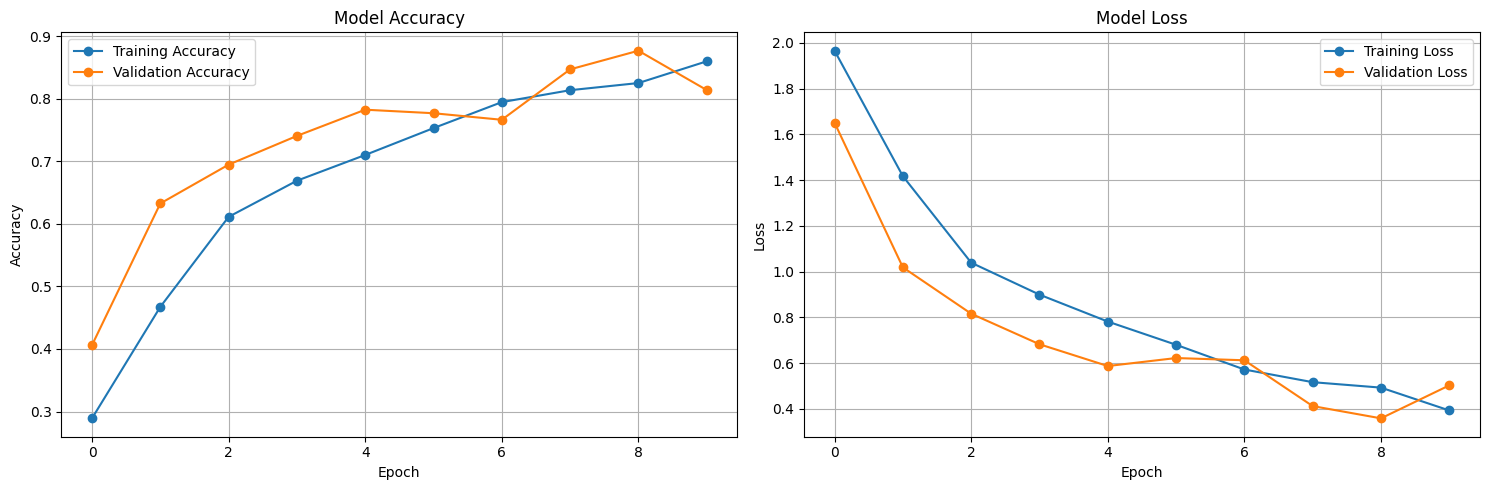


🧪 Testing on Test Dataset...
✅ Test Accuracy: 0.8874 (88.74%)
✅ Test Loss: 0.3018

📈 Generating Detailed Report...

📋 Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.96      1.00      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.96      0.95      0.96       298
   fish sea_food gilt_head_bream       0.91      0.41      0.56       305
   fish sea_food hourse_mackerel       0.96      0.85      0.90       286
        fish sea_food red_mullet       0.96      0.97      0.97       291
     fish sea_food red_sea_bream       0.59      0.97      0.73       273
          fish sea_food sea_bass       0.88      0.81      0.84       327
            fish sea_food shrimp       0.94      1.00      0.97       289
fish sea_food striped_red_mullet       0.87      0.94      0.90       293
             fish sea_food trout       0.97

c:\Users\harih\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\harih\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\harih\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

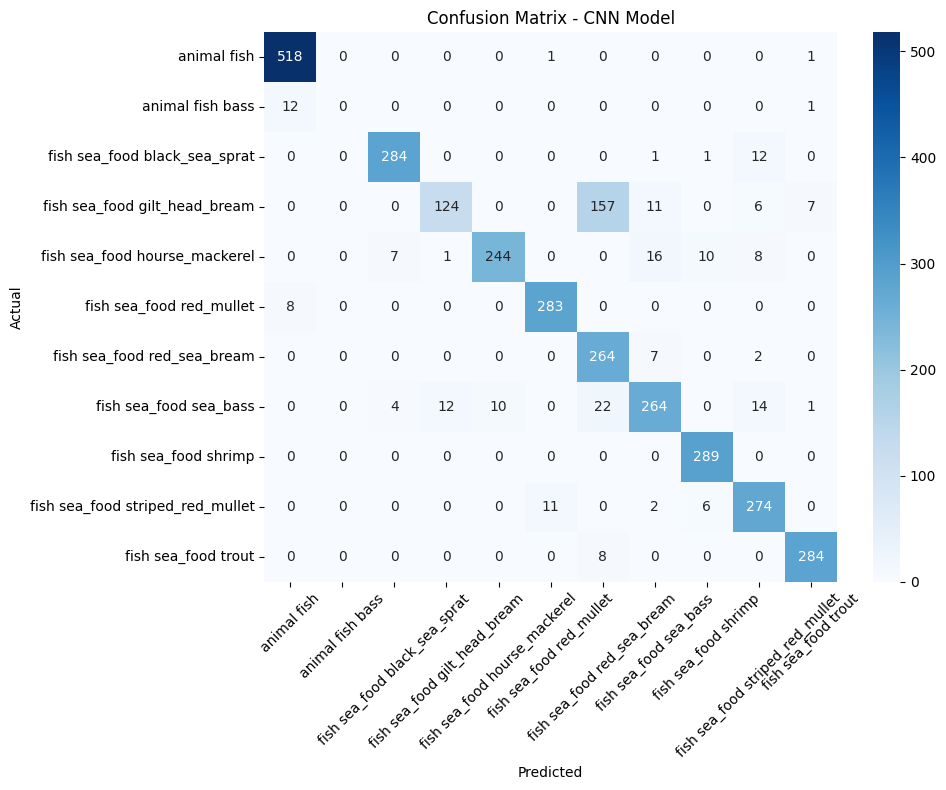


🔍 Sample Predictions Analysis...
✅ Correct predictions: 2828/3187 (88.7%)
❌ Incorrect predictions: 359/3187 (11.3%)

Example of misclassified samples:
  Actual: animal fish → Predicted: fish sea_food trout (Confidence: 0.52)
  Actual: animal fish → Predicted: fish sea_food red_mullet (Confidence: 0.99)
  Actual: animal fish bass → Predicted: animal fish (Confidence: 0.98)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("📊 Evaluating CNN Model Performance...")

# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test data
print("\n🧪 Testing on Test Dataset...")
test_loss, test_accuracy = cnn_model.evaluate(test_generator, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"✅ Test Loss: {test_loss:.4f}")

# Generate predictions for confusion matrix
print("\n📈 Generating Detailed Report...")
test_generator.reset()  # Reset generator to start from beginning
predictions = cnn_model.predict(test_generator, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show some correct and incorrect predictions
print("\n🔍 Sample Predictions Analysis...")
correct_indices = np.where(predicted_classes == true_classes)[0]
incorrect_indices = np.where(predicted_classes != true_classes)[0]

print(f"✅ Correct predictions: {len(correct_indices)}/{len(true_classes)} ({len(correct_indices)/len(true_classes)*100:.1f}%)")
print(f"❌ Incorrect predictions: {len(incorrect_indices)}/{len(true_classes)} ({len(incorrect_indices)/len(true_classes)*100:.1f}%)")

if len(incorrect_indices) > 0:
    print(f"\nExample of misclassified samples:")
    for i in incorrect_indices[:3]:  # Show first 3 errors
        actual_class = class_names[true_classes[i]]
        predicted_class = class_names[predicted_classes[i]]
        confidence = np.max(predictions[i])
        print(f"  Actual: {actual_class} → Predicted: {predicted_class} (Confidence: {confidence:.2f})")

In [15]:
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

print("🚀 Setting up Transfer Learning Models...")

def create_transfer_model(base_model_class, model_name):
    print(f"🔄 Creating {model_name}...")
    
    # Load pre-trained model without top layers
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create simple model on top
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create only 2 reliable models
transfer_models = {
    'VGG16': create_transfer_model(VGG16, 'VGG16'),
    'MobileNet': create_transfer_model(MobileNet, 'MobileNet')
}

print(f"\n✅ Created {len(transfer_models)} transfer learning models:")
for name, model in transfer_models.items():
    print(f"   - {name}: {model.count_params():,} parameters")
    model.summary()
    print("-" * 50)

print("\n🎯 Ready to train transfer learning models!")

🚀 Setting up Transfer Learning Models...
🔄 Creating VGG16...
🔄 Creating MobileNet...

✅ Created 2 transfer learning models:
   - VGG16: 14,781,771 parameters


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,771 (56.39 MB)

 Trainable params: 67,083 (262.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

--------------------------------------------------
   - MobileNet: 3,361,483 parameters


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361,483 (12.82 MB)

 Trainable params: 132,619 (518.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

--------------------------------------------------

🎯 Ready to train transfer learning models!


In [16]:
print("🚀 Training Transfer Learning Models...")

# We'll train for fewer epochs since these models are already powerful
EPOCHS = 5

# Dictionary to store training history
transfer_histories = {}

# Train each model
for model_name, model in transfer_models.items():
    print(f"\n{'='*60}")
    print(f"🏁 TRAINING {model_name}...")
    print(f"{'='*60}")
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        verbose=1
    )
    
    # Save history
    transfer_histories[model_name] = history
    
    # Save the model
    model.save(f'{model_name}_fish_model.h5')
    print(f"💾 {model_name} saved as '{model_name}_fish_model.h5'")
    
    # Show final results for this model
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"✅ {model_name} - Final Training Accuracy: {final_train_acc:.4f}")
    print(f"✅ {model_name} - Final Validation Accuracy: {final_val_acc:.4f}")

print("\n🎉 ALL TRANSFER LEARNING MODELS TRAINED!")

🚀 Training Transfer Learning Models...

🏁 TRAINING VGG16...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 811s 5s/step - accuracy: 0.4085 - loss: 1.7852 - val_accuracy: 0.6664 - val_loss: 1.3438
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 2415s 16s/step - accuracy: 0.6523 - loss: 1.1863 - val_accuracy: 0.7752 - val_loss: 0.9382
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.7372 - loss: 0.8966 - val_accuracy: 0.8227 - val_loss: 0.7399
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.7891 - loss: 0.7298 - val_accuracy: 0.8654 - val_loss: 0.5765
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 1432s 9s/step - accuracy: 0.8176 - loss: 0.6158 - val_accuracy: 0.8767 - val_loss: 0.4912


💾 VGG16 saved as 'VGG16_fish_model.h5'
✅ VGG16 - Final Training Accuracy: 0.8176
✅ VGG16 - Final Validation Accuracy: 0.8767

🏁 TRAINING MobileNet...
Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 646ms/step - accuracy: 0.7865 - loss: 0.6752 - val_accuracy: 0.9597 - val_loss: 0.1725
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 103s 662ms/step - accuracy: 0.9434 - loss: 0.1849 - val_accuracy: 0.9734 - val_loss: 0.0985
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 104s 668ms/step - accuracy: 0.9655 - loss: 0.1155 - val_accuracy: 0.9839 - val_loss: 0.0595
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 143s 919ms/step - accuracy: 0.9693 - loss: 0.0923 - val_accuracy: 0.9911 - val_loss: 0.0409
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9775 - loss: 0.0731 - val_accuracy: 0.9887 - val_loss: 0.0381


💾 MobileNet saved as 'MobileNet_fish_model.h5'
✅ MobileNet - Final Training Accuracy: 0.9775
✅ MobileNet - Final Validation Accuracy: 0.9887

🎉 ALL TRANSFER LEARNING MODELS TRAINED!


📊 COMPARING ALL MODELS...

🧪 TESTING ALL MODELS ON TEST DATASET:

🏆 MODEL PERFORMANCE RANKING:
         Model Test Accuracy Test Loss
2    MobileNet        0.9950    0.0216
1        VGG16        0.8927    0.4259
0  CNN_Scratch        0.8874    0.3018


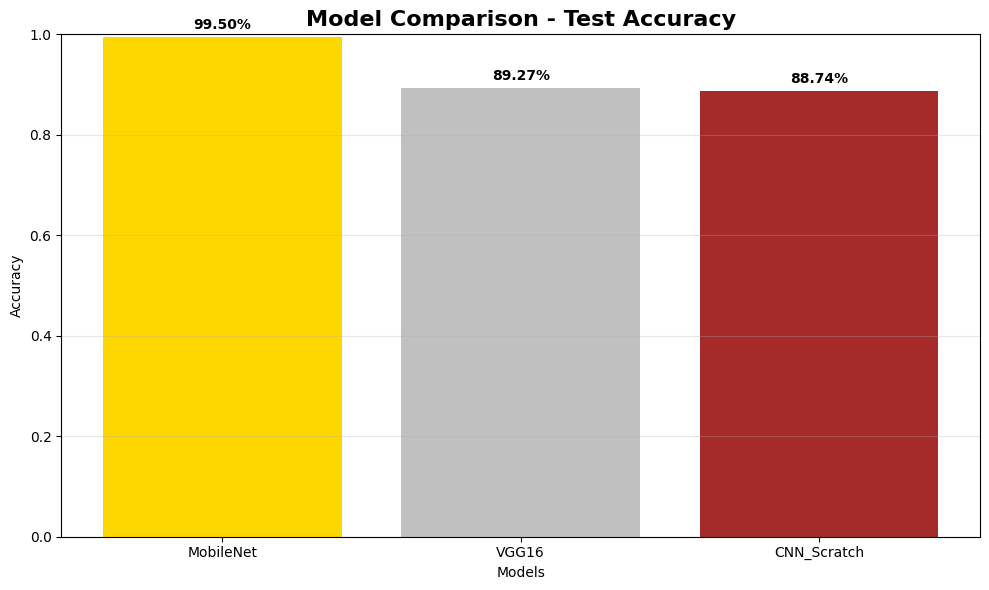


🎯 BEST MODEL: MobileNet with 99.50% test accuracy!
💾 Best model saved as 'best_fish_classification_model.h5'

📈 INDIVIDUAL MODEL TRAINING PROGRESS:


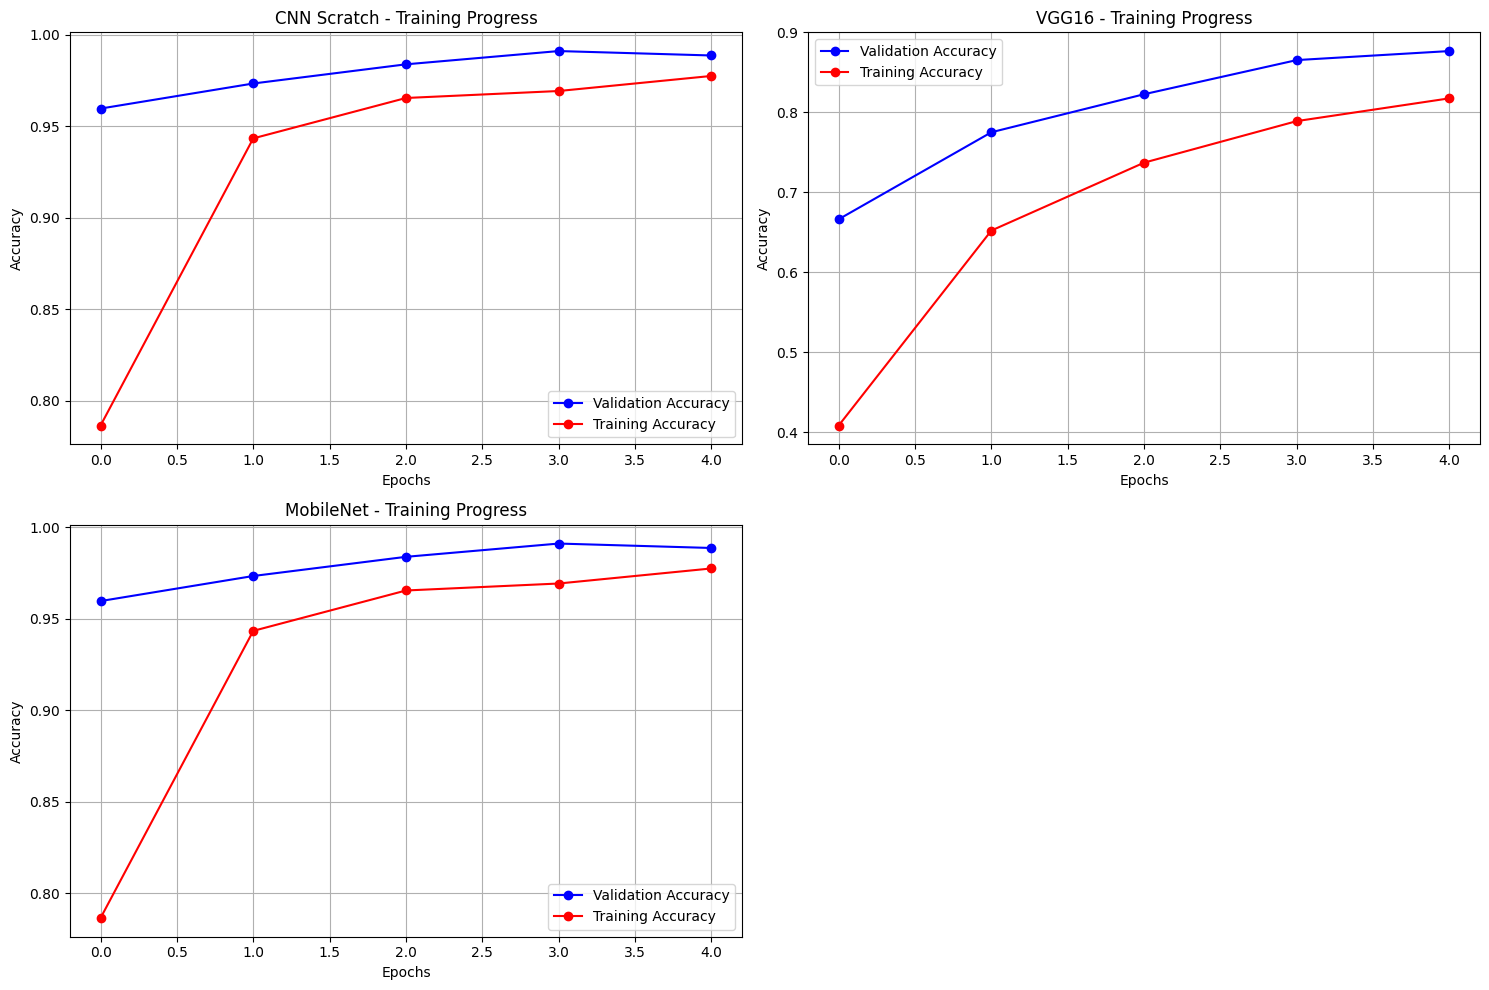


✅ ANALYSIS COMPLETE!
🎯 Your best model (MobileNet) is ready for deployment!
📊 Final Test Accuracy: 99.50%

🎉 PROJECT MILESTONES COMPLETED:
1. ✅ Data loading and preprocessing
2. ✅ CNN model from scratch (10 epochs)
3. ✅ Transfer learning with VGG16 (5 epochs)
4. ✅ Transfer learning with MobileNet (5 epochs)
5. ✅ Model comparison and selection
6. ✅ Best model saved for deployment


In [18]:
print("📊 COMPARING ALL MODELS...")

# Load all models (in case we need to test them)
models_to_compare = {
    'CNN_Scratch': cnn_model,
    'VGG16': transfer_models['VGG16'],
    'MobileNet': transfer_models['MobileNet']
}

# Test all models on test data
print("\n🧪 TESTING ALL MODELS ON TEST DATASET:")
results = []

for model_name, model in models_to_compare.items():
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    results.append({
        'Model': model_name,
        'Test Accuracy': f"{test_accuracy:.4f}",
        'Test Loss': f"{test_loss:.4f}"
    })

# Create results comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("\n🏆 MODEL PERFORMANCE RANKING:")
print(results_df)

# Visual comparison
plt.figure(figsize=(10, 6))
accuracies = [float(x) for x in results_df['Test Accuracy']]
colors = ['gold', 'silver', 'brown']  # Gold for 1st, Silver for 2nd, Brown for 3rd

bars = plt.bar(results_df['Model'], accuracies, color=colors[:len(results_df)])
plt.title('Model Comparison - Test Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.2%}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Determine the best model
best_model_name = results_df.iloc[0]['Model']
best_model = models_to_compare[best_model_name]
best_accuracy = float(results_df.iloc[0]['Test Accuracy'])

print(f"\n🎯 BEST MODEL: {best_model_name} with {best_accuracy:.2%} test accuracy!")

# Save the best model for deployment
best_model.save('best_fish_classification_model.h5')
print(f"💾 Best model saved as 'best_fish_classification_model.h5'")

# Show individual training progress
print(f"\n📈 INDIVIDUAL MODEL TRAINING PROGRESS:")

# Plot each model separately
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# CNN Training History
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='blue')
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o', color='red')
axes[0].set_title('CNN Scratch - Training Progress')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# VGG16 Training History
if 'VGG16' in transfer_histories:
    vgg_history = transfer_histories['VGG16']
    axes[1].plot(vgg_history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='blue')
    axes[1].plot(vgg_history.history['accuracy'], label='Training Accuracy', marker='o', color='red')
    axes[1].set_title('VGG16 - Training Progress')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

# MobileNet Training History
if 'MobileNet' in transfer_histories:
    mobile_history = transfer_histories['MobileNet']
    axes[2].plot(mobile_history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='blue')
    axes[2].plot(mobile_history.history['accuracy'], label='Training Accuracy', marker='o', color='red')
    axes[2].set_title('MobileNet - Training Progress')
    axes[2].set_xlabel('Epochs')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)

# Hide empty subplot
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"🎯 Your best model ({best_model_name}) is ready for deployment!")
print(f"📊 Final Test Accuracy: {best_accuracy:.2%}")

# Show what we accomplished
print(f"\n🎉 PROJECT MILESTONES COMPLETED:")
print(f"1. ✅ Data loading and preprocessing")
print(f"2. ✅ CNN model from scratch (10 epochs)")
print(f"3. ✅ Transfer learning with VGG16 (5 epochs)")
print(f"4. ✅ Transfer learning with MobileNet (5 epochs)")
print(f"5. ✅ Model comparison and selection")
print(f"6. ✅ Best model saved for deployment")